In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
from pathlib import Path
import pandas as pd

In [3]:
#path = Path('/home/ubuntu/data/autopsy/milestone/no_preprocessing')

path = Path('/home/ubuntu/data/autopsy/2014_2018/no_preprocessing/reports/k-fold-suicide-homicide')


In [4]:
df = pd.read_csv(path/'data_suicide_homicide_k_1.csv')
df.head()

,label,text,is_valid
0,Homicide,\n.MICRO.\nHEART: acute hemorrhages in the epi...,False
1,Suicide,\n.MICRO.\nNONE\n.LOCATIONNeck\n.INJURYHanging...,False
2,Homicide,\n.MICRO.\nLIVER: Moderate macrovesicular stea...,False
3,Homicide,\n.MICRO.\nHeart:\nNo significant histopatholo...,False
4,Homicide,\n.MICRO.\nNONE\n.LOCATIONTrunk\n.INJURYFirear...,False


In [5]:
df['text'][1]

'\n.MICRO.\nNONE\n.LOCATIONNeck\n.INJURYHanging.\n.INJURYDESC.\nPartially encircling the neck is a 0.75 cm brown abraded ligature furrow which anteriorly passes over the thyroid cartilage and cants upwards and backwards toward the nape of the neck lying 6.0 cm below the right ear and 3.0 cm below the left ear. No other neck trauma is present. Accompanying the body is a green electrical cord ligature which correlates with the ligature furrow of the neck. \n\n.LOCATIONHead\n.INJURYBlunt injury.\n.INJURYDESC.\nOn the left anterior forehead is a 1.0 cm linear red abrasion,.'

In [6]:
bs=32

In [7]:
data_lm = TextLMDataBunch.from_csv(path, 'data_suicide_homicide_k_1.csv')

In [8]:
data_lm.show_batch()

idx,text
0,. xxmaj the furrow crosses the anterior midline above the thyroid cartilage at a point 25 cm below the top of the head . xxmaj it dips downward to a point 4 cm right of anterior midline and 27 cm below the top of the head before canting upward and around the right side of the neck . xxmaj it also cants upward around the left side of the neck
1,"approximately 0.2 to 0.7 cm . xxmaj they travel from the decedentâs front to back . \n \n .locationtrunk \n .injuryblunt injury . \n xxup .injurydesc . \n xxmaj on the superior aspect of the right chest is a 1.5 x 1 cm , green - brown contusion . xxmaj on the central portion of the upper back is a 19 x 17 cm area of"
2,a 1 x 0.5 cm contusion involves the left chest . xxbos \n xxup .micro . \n xxup heart : xxmaj rare myocyte nuclear hypertrophy and hyperchromasia \n \n xxup lung : xxmaj patchy congestion . xxmaj the right anterior lung shows diffuse acute hemorrhage consisting of predominantly of intraalveolar erythrocytes . \n \n xxup liver : xxmaj moderate steatosis . \n \n xxup pancreas
3,"the anterior midline , is an 8.2 cm , vertically - oriented stab wound with a 0.3 cm wide blunt angle at the superior aspect and a sharp angle at the inferior aspect . xxmaj the inferior aspect is associated with a focal 0.5 x 0.1 cm red - yellow abrasion . \n \n xxmaj path : xxmaj the wound travels through the skin and subcutaneous tissues of the"
4,"curvilinear laceration of the right parieto - occipital scalp \n -- 2 x 1.2 cm , ovoid abrasion with a central 1.2 cm laceration of the left xxunk scalp \n -- 1.3 cm , curvilinear laceration superior to the attachment of the left ear \n -- xxmaj two lacerations of the anterior surface of the left ear , 1.6 and 2.0 cm , with avulsion of the"


In [9]:
learn = language_model_learner(data_lm, arch=AWD_LSTM)

In [ ]:
learn.freeze()

In [ ]:
#do some gradual unfreezing, so we don't lose the pretrained info
learn.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(8, 1e-3, moms=(0.8,0.7))

In [13]:
learn.save_encoder('fine_tuned_enc_no_pretrain')

In [14]:
data_clas = TextClasDataBunch.from_csv(path, 'data_suicide_homicide_k_1.csv', vocab=data_lm.train_ds.vocab, bs=bs)

In [15]:
data_clas.show_batch()

text,target
"xxbos \n xxup .micro . \n xxmaj heart - no significant histopathology \n \n xxmaj lungs - patchy extravasation of red blood cells into the intra - alveolar space \n \n xxmaj kidneys - no significant histopathology \n \n xxmaj liver - no significant histopathology \n \n xxmaj hippocampus - no significant histopathology \n \n xxmaj xxunk - vaginal , anal , and",Homicide
xxbos \n xxup .micro . \n xxmaj heart : xxmaj some of the cardiomyocyte nuclei are slightly enlarged . \n \n xxmaj lungs : xxmaj partially atelectatic with rare intra - alveolar macrophages . \n \n xxmaj liver : xxmaj mild lymphoplasmacytic inflammation confined to portal tracts . \n \n xxmaj kidney : xxmaj partially autolyzed with no significant histopathologic abnormalities . \n \n,Homicide
"xxbos \n xxup .micro . \n xxup brain : xxmaj scattered small ( petechial ) intraparenchymal and perivascular hemorrhages \n \n xxup heart : xxmaj no significant histopathologic findings \n \n xxup lungs : xxmaj blood in the bronchioles \n \n xxup kidneys : xxmaj no significant histopathologic findings \n \n xxup liver : xxmaj mild , predominantly macrovesicular steatosis \n \n \n",Homicide
"xxbos \n xxup .micro . \n xxup none \n .locationhead \n .injuryfirearm injury . \n xxup .injurydesc . \n xxup penetrating xxup gunshot xxup wound xxup of xxup head ( a ) \n \n xxup entrance : xxmaj on the left side of the scalp , centered 4 centimeters below the top of the head and 6 centimeters left of the anterior midline",Homicide
"xxbos \n xxup .micro . \n xxmaj brain : xxmaj non - organizing subarachnoid hemorrhage of the frontal cortex . xxmaj no significant histopathology of the hippocampus or cerebellum . \n \n xxmaj heart : xxmaj no significant histopathology . \n \n xxmaj lung : xxmaj mild emphysematous changes of the upper lobes ( septal clubbing , airspace widening ) ; scattered polarizable foreign material within",Homicide


In [54]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc_no_pretrain')
learn.freeze()

In [17]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.497361,0.740553,0.623974,00:34


In [19]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.428092,0.458193,0.802956,00:40


In [20]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.393528,0.408407,0.819376,00:55


In [21]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(3e-4,3e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.430387,0.344997,0.845649,01:04
2,0.382873,0.376847,0.840723,01:07


In [23]:
from fastai.vision import *

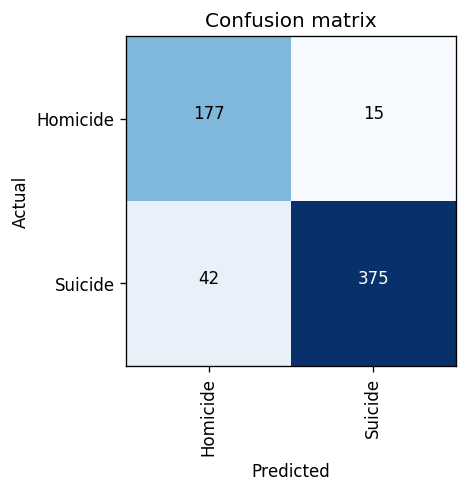

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(4,4), dpi=120)

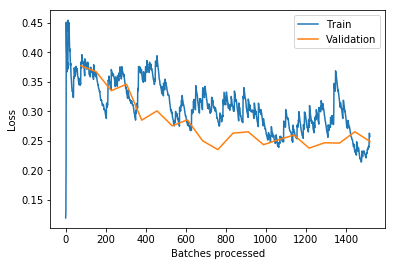

In [25]:
learn.recorder.plot_losses()

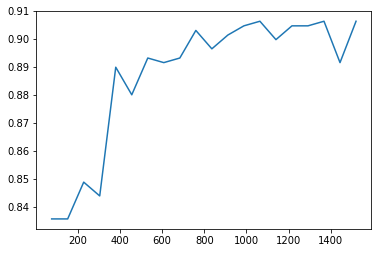

In [26]:
learn.recorder.plot_metrics()

In [51]:

def intrinsic_attention_modified(self, text:str, class_id:int=None):
        """Calculate the intrinsic attention of the input w.r.t to an output `class_id`, or the classification given by the model if `None`.
        For reference, see the Sequential Jacobian session at https://www.cs.toronto.edu/~graves/preprint.pdf
        """
        self.model.train()
        eval_dropouts(self.model)
        self.model.zero_grad()
        self.model.reset()
        ids = self.data.one_item(text)[0]
        emb = self.model[0].module.encoder(ids).detach().requires_grad_(True)                
        lstm_output = self.model[0].module(emb, from_embeddings=True)
        self.model.eval()
        cl = self.model[1](lstm_output)[0].softmax(dim=-1)
        if class_id is None: class_id = cl.argmax()
        cl[0][class_id].backward()
        attn = emb.grad.squeeze().abs().sum(dim=-1)
        attn /= attn.max() 
        tokens = self.data.single_ds.reconstruct(ids[0])
        return tokens, attn

def eval_dropouts(mod):
        module_name =  mod.__class__.__name__
        if 'Dropout' in module_name or 'BatchNorm' in module_name: mod.training = False
        for module in mod.children(): eval_dropouts(module)

TextClassificationInterpretation.intrinsic_attention = intrinsic_attention_modified
ci = TextClassificationInterpretation.from_learner(learn)

In [59]:
example = df['text'][1]

In [60]:
ci.show_intrinsic_attention(example)

In [61]:
learn.predict(example)

(<fastai.core.Category at 0x7f9bd0b0be48>, tensor(1), tensor([0.3192, 0.6808]))